### Interpretability of DNN: Visualization of extreme events
##### Assessing baseline

In [1]:
# Important to note:!
# The use of innvestigate requires specific versions of python and keras
# The model must be built according to the versions, so the weights are saved separately
# import necesssary libaries
from pathlib import Path
import pathlib
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
#for plotting
import geopandas as gpd

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from utils.utils_unet import *
from utils.utils_plot import *
from utils.DNN_models import *
from utils.utils_LRP import *


import innvestigate
import innvestigate.utils as iutils
import innvestigate.applications.imagenet
import innvestigate.utils.visualizations as ivis

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  #catch FutureWarnings so that I can find actual errors!
    
    import keras
    import keras.backend as K
    import keras.models
    #import tensorflow as tf  # this is new for custom loss function
    from keras.models import load_model
    
    from keras.layers import Input, Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D, Conv2DTranspose, UpSampling2D, Reshape
    from keras.models import Model
    
    from keras.utils import CustomObjectScope
    from keras.initializers import glorot_uniform
    import yaml

Using TensorFlow backend.


In [2]:
conf = yaml.safe_load(open("config.yaml"))
i_shape = conf['i_shape']
o_shape = conf['o_shape']

print(f'X shape: {i_shape}')
print(f'y shape: {o_shape}')
output_channels = conf['output_channels']
num_filters = conf['num_filters']
use_batchnorm = conf['use_batchnorm']
dropout = conf['dropout']
lr = conf['lr']

name_model = conf['model']
output_scaling = 1
output_crop = None

X shape: [46, 56, 31]
y shape: [46, 56, 1]


In [57]:
# load data
# load coordinates
lons_x = np.load('tmp/data/lons_y.npy')
lats_y = np.load('tmp/data/lats_y.npy')
# define time dimension
times = np.arange(np.datetime64('2016-01-01'), np.datetime64('2022-01-01')) #until validation period
times = pd.to_datetime(times)

In [45]:
def convert_to_xarray(a, vnames, time, lats_y, lons_x):
    """Convert numpy array to xarray"""
    mx= xr.DataArray(a, dims=["time","lat", "lon", "variable"],
                  coords=dict(time = time,
                              lat = lats_y, lon = lons_x, variable= vnames ))
        
    return(mx)

In [46]:
# Open the LRP data
lrpz_test = np.load('tmp/LRP/lrpz_test_DNN_UNET4.npy')  # it distributes the relevance of each neuron based on the values of the localized preactivations that are directed to it
lrp_comp_test = np.load('tmp/LRP/lrpcomp_test_DNN_UNET4.npy') # composite rule that combines the a1b0 and the z rules 
lrp_compflat_test = np.load('tmp/LRP/lrpcompflat_test_DNN_UNET4.npy') # composite rule as lrp_comp, but it applies a flat rule in the very lowest layer(s). The flat rule distributes relevance
                                                                       # uniformly to all connected neurons without considering the preactivations values.

In [47]:
xr_lrpz_test = convert_to_xarray(lrpz_test,  conf['varnames'], times, lats_y, lons_x)
xr_lrpz_comp_test =  convert_to_xarray(lrp_comp_test,  conf['varnames'], times, lats_y, lons_x)
xr_lrpz_compflat_test =  convert_to_xarray(lrp_compflat_test,  conf['varnames'], times, lats_y, lons_x)

In [48]:
# Load the baseline
BS_lrpz_test = np.load('tmp/LRP/BS_lrpz_test_DNN_UNET4.npy')
BS_lrp_comp_test = np.load('tmp/LRP/BS_lrpcomp_test_DNN_UNET4.npy')
BS_lrp_compflat_test = np.load('tmp/LRP/BS_lrpcompflat_test_DNN_UNET4.npy')

In [49]:
xr_BS_lrpz_test = convert_to_xarray(BS_lrpz_test,  conf['varnames'], times, lats_y, lons_x)
xr_BS_lrpz_comp_test =  convert_to_xarray(BS_lrp_comp_test,  conf['varnames'], times, lats_y, lons_x)
xr_BS_lrp_compflat_test =  convert_to_xarray(BS_lrp_compflat_test,  conf['varnames'], times, lats_y, lons_x)

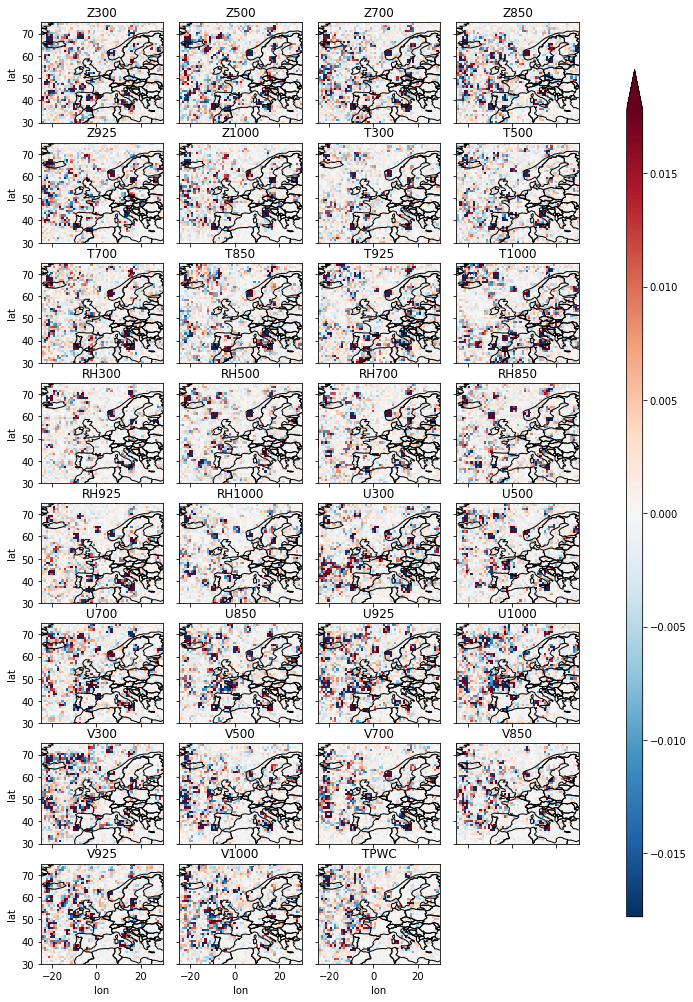

In [25]:
# Visualize awerages over time
plot_xr_rel(xr_lrpz_test.mean(dim='time'), lats_y, lons_x, conf['varnames'], 'highest_amount_precip_comp', cmap = 'RdBu_r')

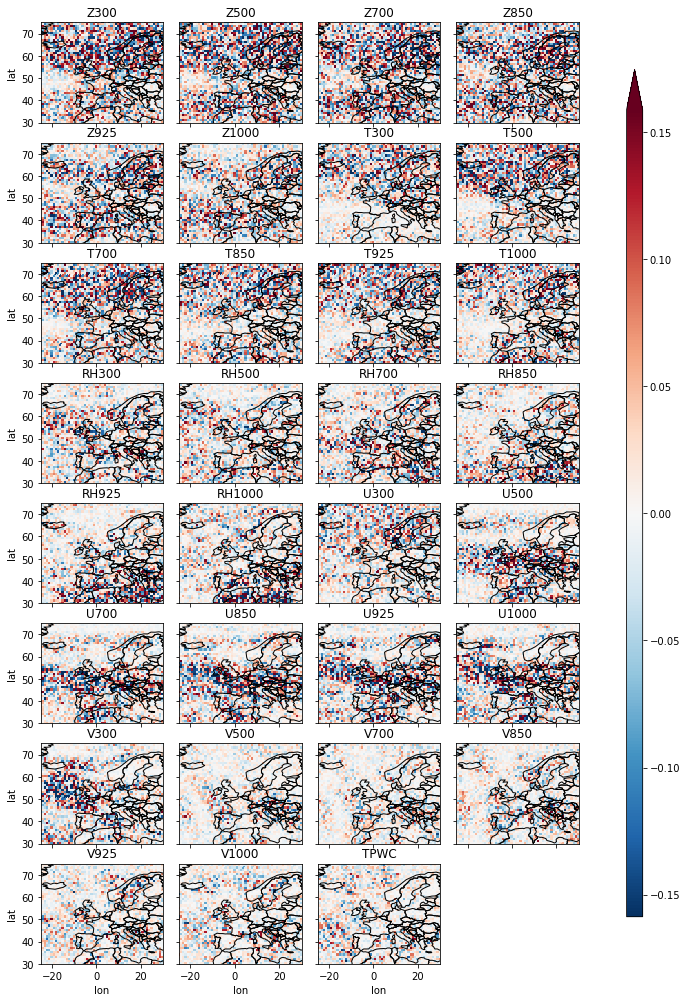

In [26]:
# Visualize awerages over time
plot_xr_rel(xr_BS_lrpz_test.mean(dim='time'), lats_y, lons_x, conf['varnames'], 'BS_highest_amount_precip_comp', cmap = 'RdBu_r')

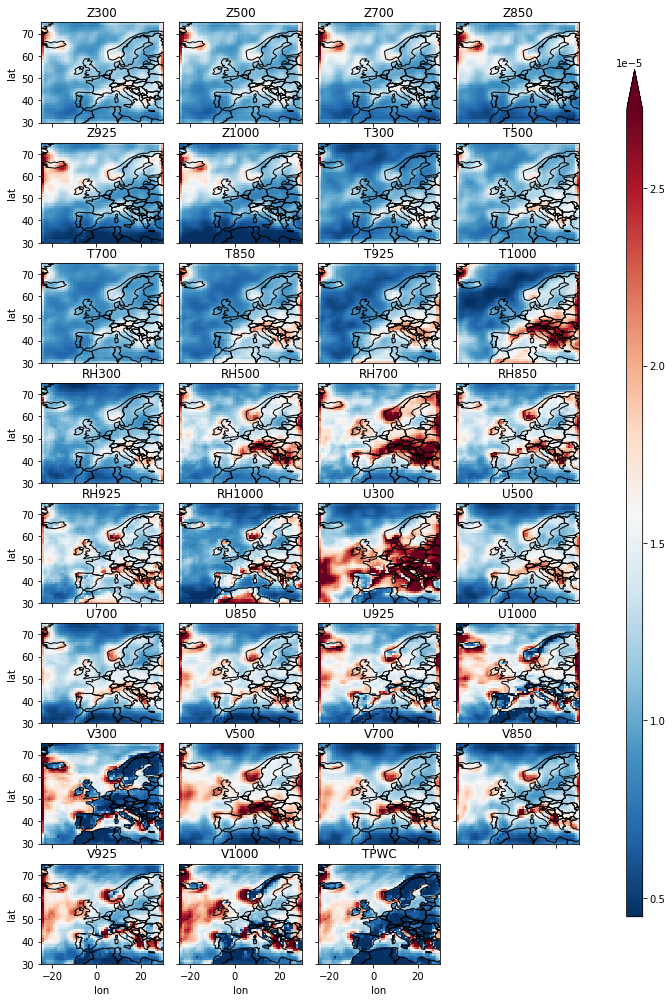

In [27]:
plot_xr_rel(xr_lrpz_comp_test.mean(dim='time'), lats_y, lons_x, conf['varnames'], 'highest_amount_precip_comp', cmap = 'RdBu_r')

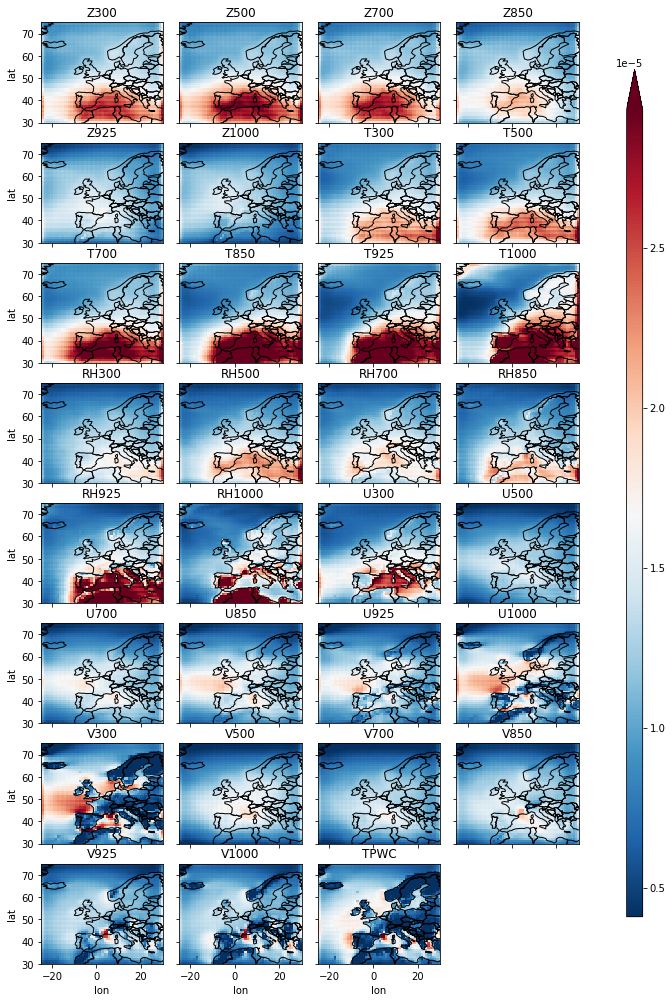

In [28]:
plot_xr_rel(xr_BS_lrpz_comp_test.mean(dim='time'), lats_y, lons_x, conf['varnames'], 'highest_amount_precip_comp', cmap = 'RdBu_r')

In [58]:
# question addressed : which patterns (predictors) made the network to predict precipitation events?
# let's pick the event: 
idx = np.where(times == '2021-07-14')
idx = int(idx[0])

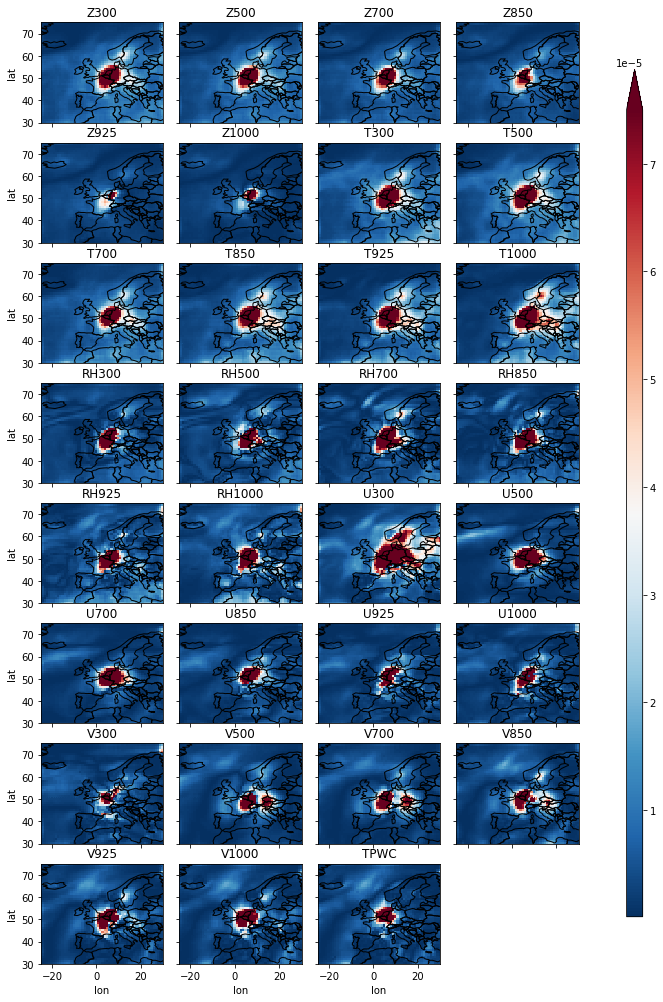

In [61]:
plot_xr_rel(xr_lrpz_comp_test[idx,:,:,:], lats_y, lons_x, conf['varnames'], 'highest_amount_precip_comp', cmap = 'RdBu_r')

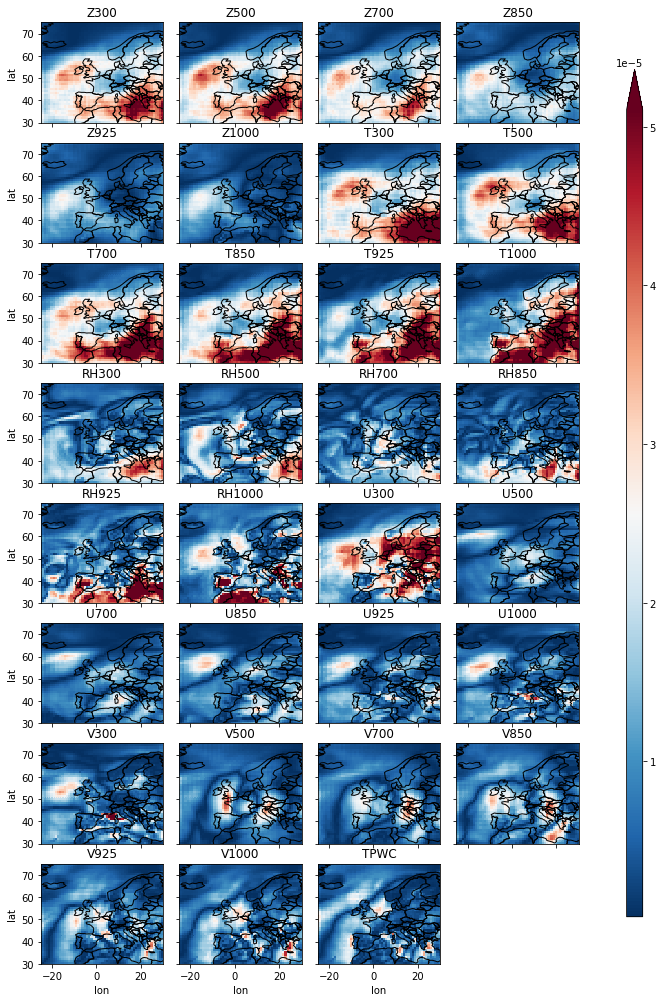

In [62]:
plot_xr_rel(xr_BS_lrpz_comp_test[idx,:,:,:], lats_y, lons_x, conf['varnames'], 'highest_amount_precip_comp', cmap = 'RdBu_r')

In [ ]:
plot_xr_rel(xr_lrpz_comp_test.mean(dim='time'), lats_y, lons_x, conf['varnames'], 'highest_amount_precip_comp', cmap = 'RdBu_r')

In [ ]:
plot_xr_rel(xr_lrpz_comp_test.mean(dim='time'), lats_y, lons_x, conf['varnames'], 'highest_amount_precip_comp', cmap = 'RdBu_r')